# Scaled Continuous Consistency Models

Simplifying, Stabilizing & Scailing Continuous-Time Consistency Models, Lu & Song, 2024.[arXiv:2410.11081]

## 1. Prepare Dataset

Define the gaussian mixture distribution as the target distribution.

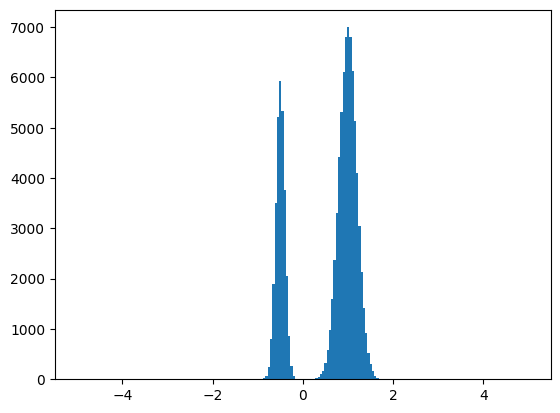

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import gmm

X, Y = gmm(100000, weights=[0.3, 0.7], mean=[-0.5, 1.0], std=[0.1, 0.2])

_ = plt.hist(X, bins=np.linspace(-5, 5, 200), label="data")

## 2. Define Model

Define MLP backbone and TrigFlow framework.

In [2]:
from flowmodels.sct import TrigFlow, ScaledContinuousCMScheduler
from utils import Backbone

COND = False
aux = 1 if not COND else 2
model = TrigFlow(Backbone(aux=aux), ScaledContinuousCMScheduler())
model

TrigFlow(
  (F0): Backbone(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): ReLU()
      (8): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (_ada_weight): _AdaptiveWeights(in_features=128, out_features=1, bias=True)
)

## 3. TrigFlow Pretraining

Pretrain the backbone with trigflow with the prepared dataset.

  0%|          | 0/1000 [00:00<?, ?it/s]

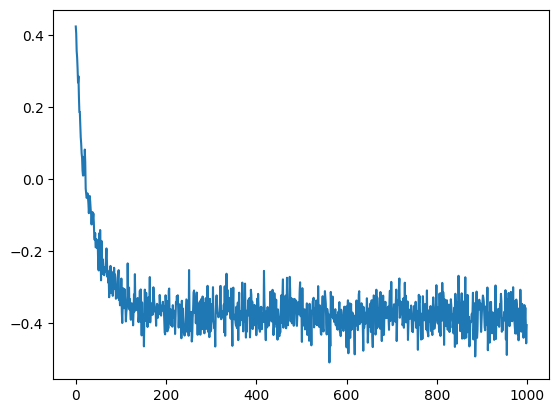

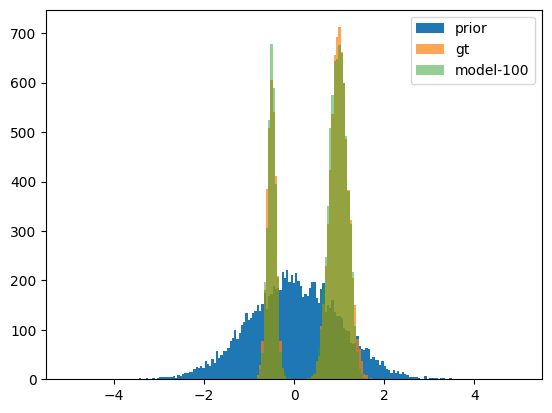

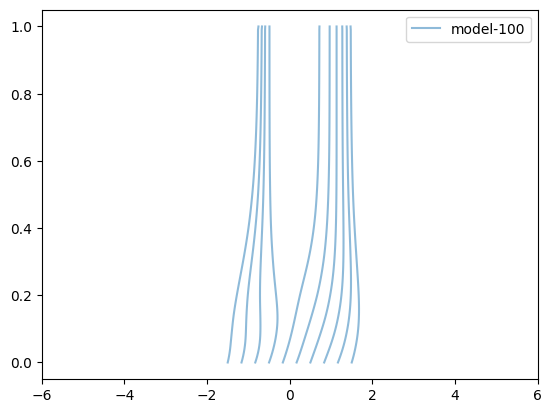

In [3]:
import torch
from tqdm.auto import tqdm

from utils import vis

# training configurations
LR = 0.001
TRAIN_STEPS = 1000
BATCH_SIZE = 2048
MU = 0.0

# train
model.train()
optim = torch.optim.Adam(model.parameters(), LR)

losses = []
with tqdm(range(TRAIN_STEPS)) as pbar:
    for i in pbar:
        indices = torch.randint(0, len(X), (BATCH_SIZE,))
        loss = model.loss(
            sample=X[indices],
            label=Y[indices] if COND else None,
        )
        # update
        optim.zero_grad()
        loss.backward()
        optim.step()

        # log
        loss = loss.detach().item()
        losses.append(loss)
        pbar.set_postfix_str(f"loss: {loss:.2f}")


plt.plot(losses)
vis(model, conditional=COND, steps=[100], _sigma_data=0.5)

## 3. Scaled Consistency Training

Train the consistency model with the prepared dataset.

  0%|          | 0/1000 [00:00<?, ?it/s]

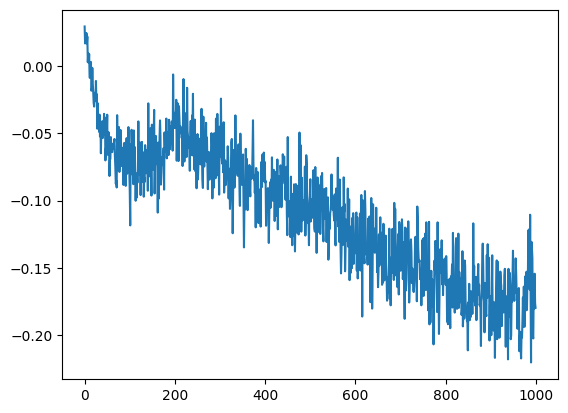

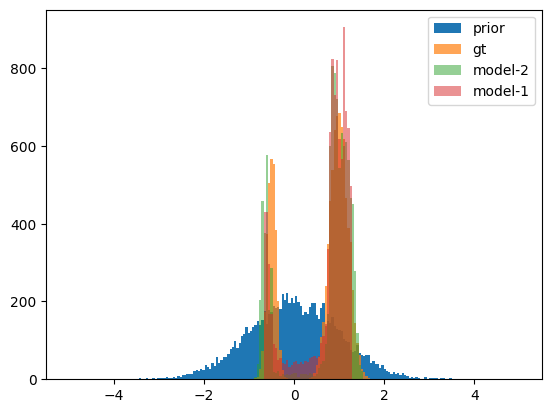

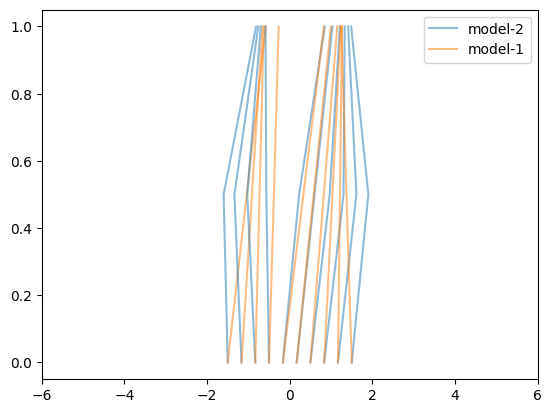

In [4]:
import torch
from tqdm.auto import tqdm

from flowmodels import ScaledContinuousCM

# training configurations
LR = 0.0001
TRAIN_STEPS = 1000
BATCH_SIZE = 2048

model = ScaledContinuousCM(model.F0, model.scheduler, tangent_warmup=200)

# train
model.train()
optim = torch.optim.Adam(model.parameters(), LR)

losses = []
with tqdm(range(TRAIN_STEPS)) as pbar:
    for i in pbar:
        indices = torch.randint(0, len(X), (BATCH_SIZE,))
        kwargs = {} if not COND else {"label": Y[indices]}
        loss = model.loss(sample=X[indices], **kwargs)
        # update
        optim.zero_grad()
        loss.backward()
        optim.step()

        # log
        loss = loss.detach().item()
        losses.append(loss)
        pbar.set_postfix_str(f"loss: {loss:.2f}")

plt.plot(losses)
vis(model, conditional=COND, steps=[2, 1], _sigma_data=0.5)